In [1]:
import sys
# This makes the gdc19 package avaialble
sys.path.append('../')
import gdc19
# Be sure to set your working directory!!!
# this is the path to the Google Drive folder
gdc19.set_data_directory('/Volumes/GoogleDrive/My Drive/utah-forge')

'/Volumes/GoogleDrive/My Drive/utah-forge'

In [2]:
import PVGeo
import vtki
import vtk
import omfvtk
import lasio

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Links:

- https://utahforge.com/studentcomp/?utm_source=Hubspot%20intro%20email010719&utm_source=hs_automation&utm_campaign=INL%20GDC%2019&utm_medium=email&utm_content=68794775&_hsenc=p2ANqtz--LMrr-vFzFD78-VnPLfeSy2tBImWRaDKacFvVBB19ebQ_Ry9Sm0hUEzE1GbNz0iRLniFjYKGNcFFJ_8V9_kxtKabsoMQ&_hsmi=68794775


Notes:

- LIVE webinar on January 25.


Data:

- UTM, zone 12N, NAD 83, NAVD 88.


-----

# File IO

This notebook runs through all of the data files given in the project and reads them into useable, spatially-referenced data object.

-----
## Well Data

Incomplete.

We'll use some of [`lasio`](https://lasio.readthedocs.io/en/latest/) for the file IO

In [4]:
las = lasio.read(gdc19.get_well_path(r'Acord 1-26_digitized_geophysical_well_log.las'))
las.curvesdict.keys()

dict_keys(['DEPT', 'BAD_RHOB', 'BITSIZE', 'CALI', 'DRHO', 'DT', 'GAMMA_RAY_SPLICE', 'GR_PROCESS', 'GR_SPLICE', 'LLD_SPLICE', 'LLM_SPLICE', 'LLS_SPLICE', 'NEUTRON_SPLICE', 'RHOB_PROCESSING', 'RHOB_SPLICE', 'SP_SLICE', 'TEMPERATURE_DEEP', 'TEMPERATURE_SHALLOW'])

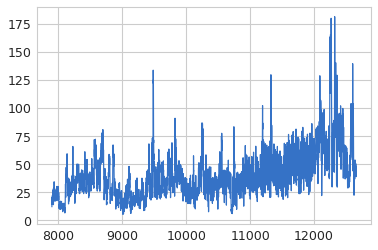

In [5]:
plt.plot(las.index, las["GAMMA_RAY_SPLICE"])

## Surfaces

Load in the 3D surface files

In [6]:
gdc19.list_filenames('surfaces')

['land_surface_vertices.csv',
 'top_granitoid_vertices.csv',
 'Negro_Mag_Fault_vertices.csv',
 '175C_vertices.csv',
 'Opal_Mound_Fault_vertices.csv',
 '225C_vertices.csv']

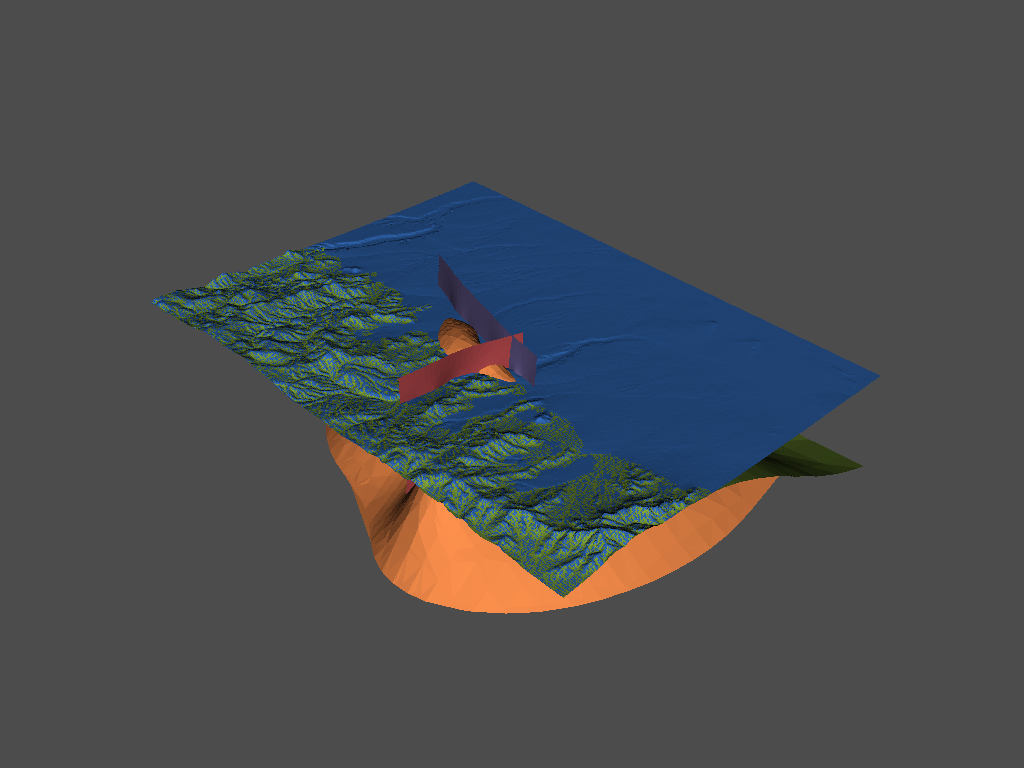

In [7]:
surfaces = vtki.MultiBlock()
surfaces[0, 'land_surface'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('land_surface_vertices.csv'))).elevation()
surfaces[1, 'top_granitoid'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('top_granitoid_vertices.csv')))
surfaces[2, 'negro_mag_fault']  = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('Negro_Mag_Fault_vertices.csv')))
surfaces[3, 'opal_mound_fault'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('Opal_Mound_Fault_vertices.csv')))

surfaces[4, '175c'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('175C_vertices.csv')))
surfaces[5, '225c'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('225C_vertices.csv')))
surfaces.plot(notebook=True, show_edges=False, multi_colors=True)
                                                       
#

In [8]:
surf = surfaces['225c']
topo = surfaces['land_surface']

In [9]:
topo

(PolyData)0xb2f7fdf48

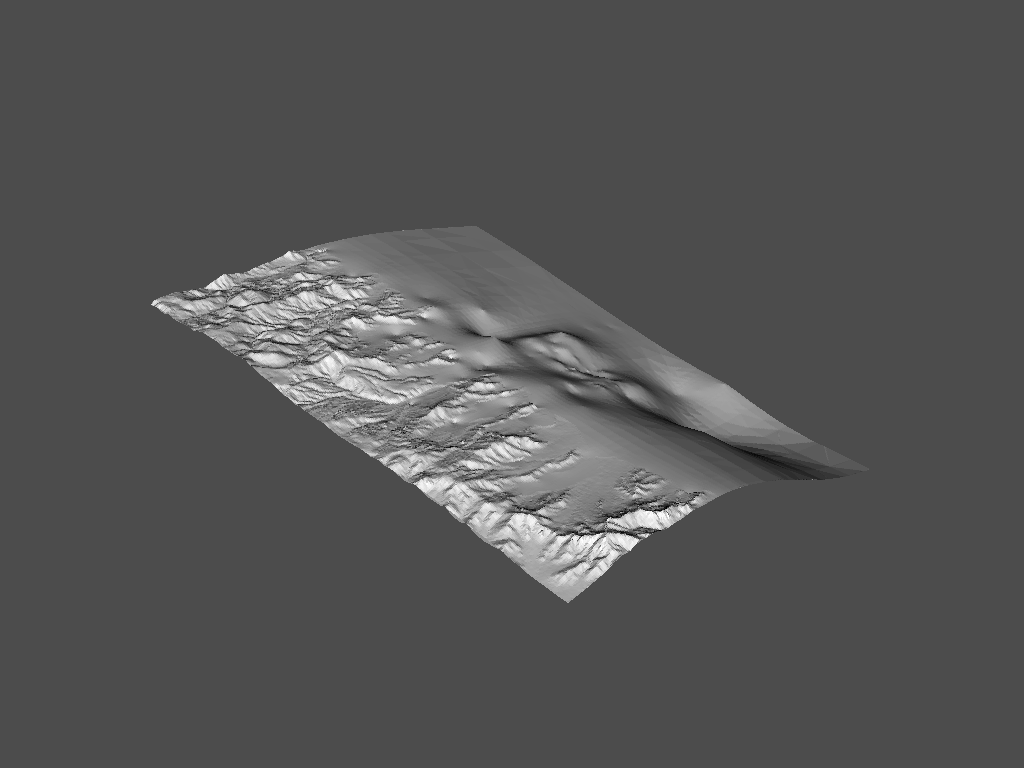

In [10]:
surfaces['top_granitoid'].plot(show_edges=False)#.save('top_granitoid.vtk')

## Temperature Data

Not sure what else can be done with this

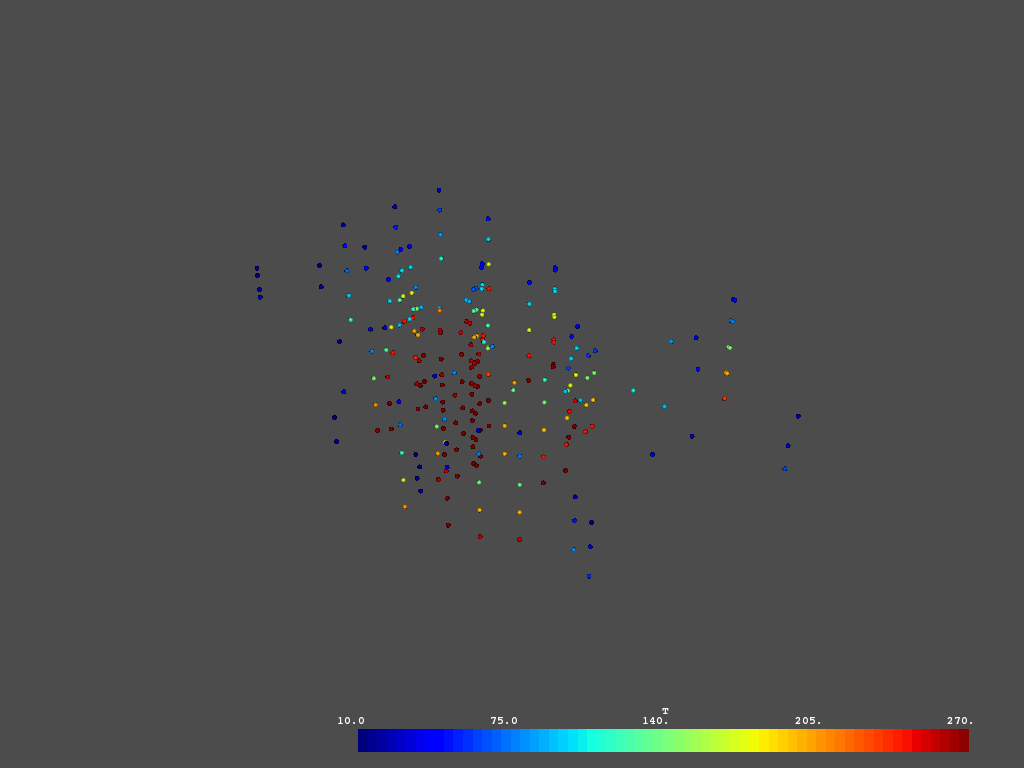

In [11]:
# Temperature data
temp = PVGeo.pointsToPolyData(
        pd.read_csv(
            gdc19.get_temperature_path('well_based_temperature.csv')
            )
        )
temp.plot(notebook=True, render_points_as_spheres=True)

## Injection Data

Not sure how to use these data yet...

In [12]:
injections = []
for f in gdc19.list_filenames('injection'):
    injections.append(pd.read_csv(gdc19.get_injection_path(f)))

In [13]:
injections[0].head()

,Time (hr),Pressure (psi),Pressure (MPa)
0,0.000000,11.839995,0.081634
1,0.001389,11.839508,0.081631
2,0.002778,11.848282,0.081691
3,0.004167,11.853885,0.081730
4,0.005556,11.858296,0.081760


In [14]:
injections[1].head()

,Time (hr),Flow (barrel/min),Flow (Liter/min)
0,13.152500,0.1,15.898729
1,13.152778,0.2,31.797459
2,13.153056,0.2,31.797459
3,13.153333,0.2,31.797459
4,13.153611,0.3,47.696188


## Drilling

Not sure yet

## GIS Data


```
conda install gdal
```

Tasks:

- [x] Load and associate textures to the topography
- [x] Load shapefiles
- [ ] Load shape file attribute from dbf

In [15]:
shapes = gdc19.read_shape_file(gdc19.get_shp_path('FORGE_Outline'), z_fill=topo.center[2])
shapes

(MultiBlock)0xb2f9919a8

In [16]:
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('Geologic_map_on_air_photo.tif'), 
                          'geo-air')
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('Geologic_map_no_quaternary.tif'), 
                          'geo-no-q')
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('topographic_map.tif'), 
                          'topo-map')

In [17]:
topo

(PolyData)0xb2f7fdf48

# Integrated Scene

In [18]:
p = vtki.BackgroundPlotter()
p.add_bounds_axes()

(vtkRenderingAnnotationPython.vtkCubeAxesActor)0xb2f991a08

In [19]:
p.add_mesh(temp, cmap='coolwarm', name='temp', 
           point_size=10, render_points_as_spheres=True,
           stitle='Temperature')
p.add_mesh(surfaces['negro_mag_fault'], 
           name='negro_mag_fault', show_edges=False, color='blue')
p.add_mesh(surfaces['opal_mound_fault'], 
           name='opal_mound_fault', show_edges=False, color='orange')

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0xb40d5c648

In [20]:
# We can update this cell to change the texture
p.add_mesh(topo, 
           texture='geo-air', 
           show_edges=False, 
           name='topo', 
           reset_camera=False)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0xb2f991dc8

In [21]:
clipper = vtki.Clip(surfaces['175c'], plotter=p, 
                    continuous_update=False,
                    outline=False,
                    display_params=dict(
                        name='175c', show_edges=False, color='grey'
                        )
                    )


interactive(children=(FloatSlider(value=336777.449678, continuous_update=False, description='location', max=34…

In [22]:
# Add the shape file stuff
p.add_mesh(shapes['FORGE site'], name='FORGE_Outline')

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0xb2f991588